In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

### Data wrangling


In [2]:
with open("../data/tinyshakespeare.txt", "r") as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}


# encoder: take a string, output a list of integers
def encode(s):
    return [stoi[c] for c in s]


# decoder: take a list of integers, output a string
def decode(l):
    return "".join([itos[i] for i in l])


data = torch.tensor(encode(text), dtype=torch.long)

n = int(0.9 * data.nelement())
train_data = data[:n]
val_data = data[n:]


{
    "data": data.shape,
    "train": train_data.shape,
    "validation": val_data.shape,
    "sample": data[:10],
}

{'data': torch.Size([1115394]),
 'train': torch.Size([1003854]),
 'validation': torch.Size([111540]),
 'sample': tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])}

In [3]:
batch_size = 32  # How many independent sequences will we process in parallel?
block_size = 8  # What is the maximum context length for predictions?
n_embed = 32  # Size of embeddings
max_steps = 10_000  # Learning
lr = 1e-3  # Learning rate

In [4]:
torch.manual_seed(1337)


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y

### Neural Net


In [5]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.key = nn.Linear(in_features=n_embed, out_features=head_size, bias=False)
        self.query = nn.Linear(in_features=n_embed, out_features=head_size, bias=False)
        self.value = nn.Linear(in_features=n_embed, out_features=head_size, bias=False)

        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)  # (B, T, C)
        q = self.query(x)  # (B, T, C)

        # Compute attention scores (affinities)
        wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, C) @ (B, C, T) → (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)

        # Weighted aggregation of values
        v = self.value(x)  # (B, T, C)
        out = wei @ v  # (B, T, T) @ (B, T, C) => (B, T, C)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)


class FeedForward(nn.Module):
    "A simple linear layer followed by a non linearity"

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.self_attention_head = MultiHeadAttention(4, n_embed // 4)
        self.feed_forward = FeedForward(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)  # Language modelling head

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T))  # (T, C)
        x = tok_emb + pos_emb  # Why is `+` the preferred choice here?
        x = self.self_attention_head(x)
        x = self.feed_forward(x)  # (B, T, C)
        logits = self.lm_head(x)

        if targets is None:  # Targets will be none during inference
            loss = None
        else:
            B, T, C = logits.shape  # Batch, Time, Embedding
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

### Quick test


In [6]:
torch.manual_seed(1337)
xb, yb = get_batch("train")

torch.manual_seed(1337)
m = BigramLanguageModel()

logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# fmt: off
print(
    decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())
)

torch.Size([256, 65])
tensor(4.1861, grad_fn=<NllLossBackward0>)

k&yxYXjp
VBWlJ:o3mt-M heHWb Hlsq&ZdojOugDN'!Aku?AvwQe&UFdExeo!Fl3jCUXbeCRn:.;nhr;oWNuyRHIBy$UTGK3aiO


### Training


In [7]:
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)

In [8]:
losses = []

for step in range(max_steps):
    # Get a minibatch
    xb, yb = get_batch("train")

    # Evaluate the loss
    logits, loss = m(xb, yb)

    losses.append(loss.item())

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step == 0:
        print(f"start={loss.item()}")

print(f"end={loss.item()}")

start=4.208947658538818
end=2.137702465057373


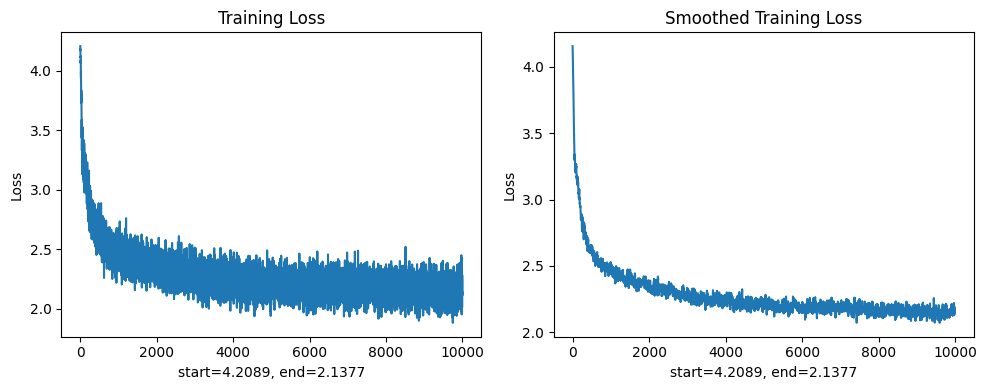

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot losses
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")
ax1.set_ylabel("Loss")

# Plot rolling
rolling = np.convolve(losses, np.ones(10), "valid") / 10
ax2.plot(rolling)
ax2.set_title("Smoothed Training Loss")
ax2.set_xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")
ax2.set_ylabel("Loss")

plt.tight_layout()
plt.show()

### Inference


In [10]:
tokens = m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=400)

print(decode(tokens[0].tolist()))


Winour saintit Man ith and mose, yumping of me thin,
An inte am sirp ther kur dawe sill word?
My this of I dreplot watherontcen thor be to me nim?
LUKING Yof magos, undd it mamefr pelds, whof's ma to therss park,
GeNir dy PEY:
Wive thers'd fice!

CAnd, lee,
And a nepy chy, I Poong thin. Whis Gilly ther a theing and ar it ther, my her sill thenen, fore, wills unes.

KI creart?

HEO:
I harpenturothe
